In [2]:

# coding: utf-8

# In[1]:


import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from torch.autograd import Variable

get_ipython().run_line_magic('pylab', 'inline')


# In[2]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Parameter
import math
from core import metrics


Populating the interactive namespace from numpy and matplotlib


In [3]:
class ModuleWrapper(nn.Module):
    """Wrapper for nn.Module with support for arbitrary flags and a universal forward pass"""

    def __init__(self):
        super(ModuleWrapper, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x):
        for module in self.children():
            x = module(x)
        return x


class LinearVariance(ModuleWrapper):
    def __init__(self, in_features, out_features, bias=True):
        super(LinearVariance, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.sigma = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.sigma.size(1))
        self.sigma.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

    def forward(self, x):
        lrt_mean = self.bias
        lrt_std = torch.sqrt_(1e-16 + F.linear(x * x, self.sigma * self.sigma))
        if self.training:
            eps = Variable(lrt_std.data.new(lrt_std.size()).normal_())
        else:
            eps = 0.0
        return lrt_mean + eps * lrt_std

In [4]:
x1, y1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 500).T
x1, y1 = np.array(list(zip(x1, y1))), np.zeros(len(x1))

x2, y2 = np.random.multivariate_normal([3, 5], [[1, 0], [0, 1]], 500).T
x2, y2 = np.array(list(zip(x2, y2))), np.ones(len(x2))

Xtr, ytr = np.vstack([x1, x2]).astype(float32),  np.hstack([y1, y2]).astype(long)

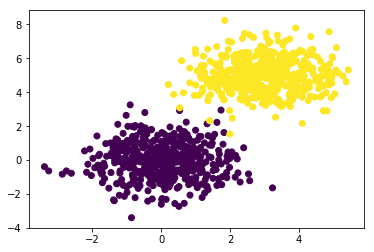

In [5]:

# In[4]:


pylab.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr)


In [6]:
greed = []

for xi in np.arange(-10, 10, 0.2):
    for yi in np.arange(-10, 10, 0.2):
        greed += [[xi, yi]]
        
greed = np.array(greed).astype(float32)

In [7]:
greed.shape

(10000, 2)

In [8]:
x1, y1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 500).T
x1, y1 = np.array(list(zip(x1, y1))), np.zeros(len(x1))

x2, y2 = np.random.multivariate_normal([3, 5], [[1, 0], [0, 1]], 500).T
x2, y2 = np.array(list(zip(x2, y2))), np.ones(len(x2))

Xte, yte = np.vstack([x1, x2]).astype(float32),  np.hstack([y1, y2]).astype(long)

/home/alliedtoasters/miniconda3/envs/ptrch/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 loss = 0.703 acc_tr = 0.500 acc_te = 0.500
1000 loss = 0.687 acc_tr = 0.500 acc_te = 0.500
2000 loss = 0.668 acc_tr = 0.500 acc_te = 0.500
3000 loss = 0.649 acc_tr = 0.500 acc_te = 0.500
4000 loss = 0.630 acc_tr = 0.991 acc_te = 0.988
5000 loss = 0.611 acc_tr = 0.725 acc_te = 0.719
6000 loss = 0.595 acc_tr = 0.732 acc_te = 0.729
7000 loss = 0.580 acc_tr = 0.739 acc_te = 0.739
8000 loss = 0.566 acc_tr = 0.751 acc_te = 0.747


KeyboardInterrupt: 

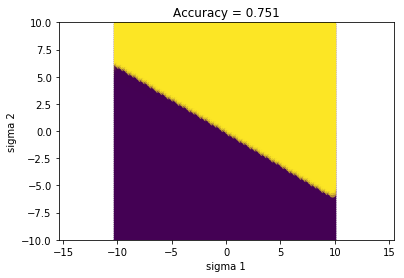

In [9]:
# In[7]:


model = torch.nn.Sequential(
  torch.nn.Linear(2, 1),
  torch.nn.LeakyReLU(),
  torch.nn.Linear(1, 2),
  torch.nn.Softmax()
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for t in range(200000):
    y_pred = model(Variable(torch.from_numpy(Xtr)))
    ypt = Variable(torch.from_numpy(ytr)).long()
    loss = loss_fn(y_pred, ypt)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    y_te = model(Variable(torch.from_numpy(Xte)))
    
    if t % 1000 == 0:
        for i in range(100):
            y_te += model(Variable(torch.from_numpy(Xte))) 
        y_te /= 101.
        
        print(t, 
              'loss = %.3f' % loss.item(), 
              'acc_tr = %.3f' % np.mean(y_pred.argmax(1).numpy() == ypt.numpy()),
              'acc_te = %.3f' % np.mean(y_te.argmax(1).numpy() == Variable(torch.from_numpy(ytr)).long().numpy()))

        ygreed = model(Variable(torch.from_numpy(greed)))
        
        for i in range(100):
            ygreed += model(Variable(torch.from_numpy(greed)))
        

        plt.scatter(greed[:, 0], greed[:, 1], c=ygreed.argmax(1).numpy(), alpha=0.5)
        plt.axis('equal')
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.title('Accuracy = %.3f' % np.mean(y_pred.argmax(1).numpy() == ypt.numpy()))
        plt.xlabel('sigma 1')
        plt.ylabel('sigma 2')
        plt.savefig('img/%s.png' % t)






In [25]:
argx = Variable(torch.from_numpy(Xtr))

y_pred1 = model(argx)
y_pred2 = model(argx)

arr1 = y_pred1.detach().numpy()
arr2 = y_pred2.detach().numpy()

np.array_equal(arr2, arr2)

/home/alliedtoasters/miniconda3/envs/ptrch/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


True

In [15]:
y_pred1

tensor([[ 6.5977e-01,  3.4023e-01],
        [ 3.7901e-01,  6.2099e-01],
        [ 3.7706e-01,  6.2294e-01],
        ...,
        [ 3.0436e-01,  6.9564e-01],
        [ 3.1519e-01,  6.8481e-01],
        [ 3.0342e-01,  6.9658e-01]])

In [22]:
arr1 = y_pred1.detach().numpy()
arr2 = y_pred2.detach().numpy()

In [24]:
np.array_equal(arr1, arr2)

True